# Multiple Gravity Assist trajectories & DSM

Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.

## Context

This example demonstrates how Multiple Gravity Assist (MGA) transfer trajectories 
with or without Deep Space Maneuvers (DSM) can be simulated.
 
In addition, this example show how the results, such as partial $\Delta$V's, total $\Delta$V and Time of Flight
values can be retrieved from the transfer object.

A complete guide on transfer trajectory design is given on [this page](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/astrodynamics/trajectory_design.html) of tudat user documentation.

## Import statements

The required import statements are made here, at the very beginning.

Some standard modules are first loaded: numpy and matplotlib.pyplot.

Then, the different modules of tudatpy that will be used are imported.

In [1]:
# Load standard modules
import numpy as np
# Uncomment the following to make plots interactive
# %matplotlib widget
import matplotlib.pyplot as plt

# Load tudatpy modules
from tudatpy.kernel.trajectory_design import transfer_trajectory
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.util import result2array
from tudatpy.kernel import constants

## MGA transfer without DSMs

First, let's explore a Multiple Gravity Assist transfer trajectory with no additional Deep Space Maneuvers.

### Setup and inputs

A simplified system of bodies suffices for this application, with the Sun as central body. The planets that are visited for a GA are defined in the list `transfer_body_order`.

The departure and arrival orbit can be specified, but there are not mendatory. If not specified, the departure and arrival planets are considered swing-by nodes.
Departures and arrivale at the edge of the Sphere Of Indfluence (SOI) of a node can be done by specifying an eccentricity of 0 and an infinite semi-major axis.

In this example, the spacecraft departs from the edge of Earth’s SOI and is inserted into a highly elliptical orbit around Saturn.

The fact that no DSMs are used is indicated by the use of a unpowered and unperturbed leg type.

In [2]:
# Create a system of simplified bodies (create all main solar system bodies with their simplest models)
bodies = environment_setup.create_simplified_system_of_bodies()
central_body = 'Sun'

# Define the order of bodies (nodes) for gravity assists
transfer_body_order = ['Earth', 'Venus', 'Venus', 'Earth',  'Jupiter',  'Saturn']

# Define the departure and insertion orbits
departure_semi_major_axis = np.inf
departure_eccentricity = 0.

arrival_semi_major_axis = 1.0895e8 / 0.02
arrival_eccentricity = 0.98

# Define the type of leg used between bodies
leg_type = transfer_trajectory.unpowered_unperturbed_leg_type

### Create transfer settings and transfer object

The specified inputs can not be used directly, but they have to be translated to distinct settings, relating to either the nodes (GAs at planets) or legs (trajectories in between planets). These settings are, in turn, used to create the transfer trajectory object.

In [3]:
# Define the trajectory settings for both the legs and at the nodes
transfer_leg_settings, transfer_node_settings = transfer_trajectory.mga_transfer_settings(
    transfer_body_order,
    leg_type,
    departure_orbit = ( departure_semi_major_axis, departure_eccentricity ),
    arrival_orbit = ( arrival_semi_major_axis, arrival_eccentricity) )

# Create the transfer calculation object
transfer_trajectory_object = transfer_trajectory.create_transfer_trajectory(
    bodies,
    transfer_leg_settings,
    transfer_node_settings,
    transfer_body_order,
    central_body )

### Define transfer parameters

The advantage of having a transfer trajectory object is that it allows for analyzing many different sets of transfer parameters for the defined transfer settings. For this first part without DSMs, the transfer parameters only constitute the times at which the powered GA’s are executed, i.e. at the nodes. Since the magnitude and direction of each  is determined by the planet positions at the node times, there is no need to specify node free parameters.
There are no DSMs in between the planets, i.e. on the legs, so there is also no need to specify leg free parameters.
However, for compatibility reasons, it is required to define the free parameters as a list containing empty arrays.

In [4]:
# Define times at each node
julian_day = constants.JULIAN_DAY
node_times = list( )
node_times.append( ( -789.8117 - 0.5 ) * julian_day )
node_times.append( node_times[ 0 ] + 158.302027105278 * julian_day )
node_times.append( node_times[ 1 ] + 449.385873819743 * julian_day )
node_times.append( node_times[ 2 ] + 54.7489684339665 * julian_day )
node_times.append( node_times[ 3 ] + 1024.36205846918 * julian_day )
node_times.append( node_times[ 4 ] + 4552.30796805542 * julian_day )

# Define free parameters per leg (for now: none)
leg_free_parameters = list( )
for i in transfer_leg_settings:
    leg_free_parameters.append( np.zeros(0))
    
# Define free parameters per node (for now: none)
node_free_parameters = list( )
for i in transfer_node_settings:
    node_free_parameters.append( np.zeros(0))

### Evaluate transfer

The transfer parameters are now used to evaluate the transfer trajectory, which means that the astrodynamical propagation is now performed.

In [5]:
# Evaluate the transfer with given parameters
transfer_trajectory_object.evaluate( node_times, leg_free_parameters, node_free_parameters )

### Extract results and plot trajectory
Last but not least, with the transfer trajectory computed, we can now analyse how it was carried.

#### Print results
Having evaluated the transfer trajectory, it is now possible to extract various transfer characteristics, such as the $\Delta$V and Time of Flight values.
Then, the definition of the transfer parameters can be plotted using the `transfer_trajectory.print_parameter_definitions()` function.

In [6]:
# Print the total DeltaV and time of Flight required for the MGA
print('Total Delta V of %.3f m/s and total Time of flight of %.3f days\n' % \
    (transfer_trajectory_object.delta_v, transfer_trajectory_object.time_of_flight / julian_day))

# Print the DeltaV required during each leg
print('Delta V per leg: ')
for i in range(len(transfer_body_order)-1):
    print(" - between %s and %s: %.3f m/s" % \
        (transfer_body_order[i], transfer_body_order[i+1], transfer_trajectory_object.delta_v_per_leg[i]))
print()

# Print the DeltaV required at each node
print('Delta V per node : ')
for i in range(len(transfer_body_order)):
    print(" - at %s: %.3f m/s" % \
        (transfer_body_order[i], transfer_trajectory_object.delta_v_per_node[i]))
print()

# Print transfer parameter definitions
print("Transfer parameter definitions:")
transfer_trajectory.print_parameter_definitions(transfer_leg_settings, transfer_node_settings)

Total Delta V of 4930.633 m/s and total Time of flight of 6239.107 days

Delta V per leg: 
 - between Earth and Venus: 0.000 m/s
 - between Venus and Venus: 0.000 m/s
 - between Venus and Earth: 0.000 m/s
 - between Earth and Jupiter: 0.000 m/s
 - between Jupiter and Saturn: 0.000 m/s

Delta V per node : 
 - at Earth: 2754.635 m/s
 - at Venus: 1090.659 m/s
 - at Venus: 615.765 m/s
 - at Earth: 0.009 m/s
 - at Jupiter: 0.000 m/s
 - at Saturn: 469.565 m/s

Transfer parameter definitions:
Parameter 0: Node time 0
Parameter 1: Node time 1
Parameter 2: Node time 2
Parameter 3: Node time 3
Parameter 4: Node time 4
Parameter 5: Node time 5



#### Plot the transfer
The state throughout the transfer can be retrieved from the transfer trajectory object, here at 500 instances per leg, to visualize the transfer.

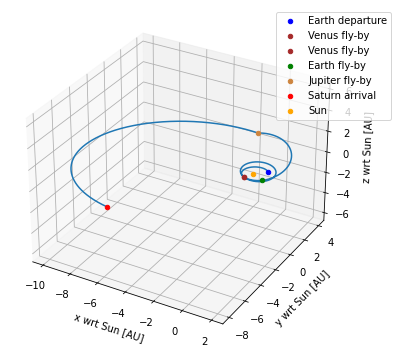

In [7]:
# Extract the state history
state_history = transfer_trajectory_object.states_along_trajectory(500)
fly_by_states = np.array([state_history[node_times[i]] for i in range(len(node_times))])
state_history = result2array(state_history)
au = 1.5e11

# Plot the transfer
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
# Plot the trajectory from the state history
ax.plot(state_history[:, 1] / au, state_history[:, 2] / au, state_history[:, 3] / au)
# Plot the position of the nodes
ax.scatter(fly_by_states[0, 0] / au, fly_by_states[0, 1] / au, fly_by_states[0, 2] / au, color='blue', label='Earth departure')
ax.scatter(fly_by_states[1, 0] / au, fly_by_states[1, 1] / au, fly_by_states[1, 2] / au, color='brown', label='Venus fly-by')
ax.scatter(fly_by_states[2, 0] / au, fly_by_states[2, 1] / au, fly_by_states[2, 2] / au, color='brown', label='Venus fly-by')
ax.scatter(fly_by_states[3, 0] / au, fly_by_states[3, 1] / au, fly_by_states[3, 2] / au, color='green', label='Earth fly-by')
ax.scatter(fly_by_states[4, 0] / au, fly_by_states[4, 1] / au, fly_by_states[4, 2] / au, color='peru', label='Jupiter fly-by')
ax.scatter(fly_by_states[5, 0] / au, fly_by_states[5, 1] / au, fly_by_states[5, 2] / au, color='red', label='Saturn arrival')
# Plot the position of the Sun
ax.scatter([0], [0], [0], color='orange', label='Sun')
# Add axis labels and limits
ax.set_xlabel('x wrt Sun [AU]')
ax.set_ylabel('y wrt Sun [AU]')
ax.set_zlabel('z wrt Sun [AU]')
ax.set_xlim([-10.5, 2.5])
ax.set_ylim([-8.5, 4.5])
ax.set_zlim([-6.5, 6.5])
# Put legend on the right
ax.legend(bbox_to_anchor=[1.15, 1])
plt.tight_layout()
plt.show()

## MGA-DSM transfer

This next part of the example now makes use of Deep Space Maneuvers in between the nodes.
The general approach is identical to the example without DSMs, with some modifications to the inputs and transfer parameters.

### Setup and inputs
Again, a simplified system of bodies suffices. In this case transfer to Mercury is considered with GA's at Earth and Venus. An important difference is that now the `dsm_velocity_based_leg_type` is required. Departure and arrival orbits and the central body are not specified here, as they are defined further on where they are used to create the transfer settings.

In [8]:
# Create simplified bodies
bodies = environment_setup.create_simplified_system_of_bodies()

# Define a new order of bodies (nodes)
transfer_body_order = ['Earth', 'Earth', 'Venus', 'Venus',  'Mercury']

# Define the type of leg between bodies, now with DSM
leg_type = transfer_trajectory.dsm_velocity_based_leg_type

### Create transfer settings and transfer object
The transfer settings are created with departure and arrival orbits at the edge of the SOI of the corresponding bodies. The Sun is again taken as central body for the transfer trajectory object

In [9]:
# Define the MGA transfer settings
transfer_leg_settings, transfer_node_settings = transfer_trajectory.mga_transfer_settings(
    transfer_body_order,
    leg_type,
    departure_orbit=(np.inf, 0.0),
    arrival_orbit=(np.inf, 0.0))

# Create the transfer calculation object
transfer_trajectory_object = transfer_trajectory.create_transfer_trajectory(
    bodies,
    transfer_leg_settings,
    transfer_node_settings,
    transfer_body_order,
    'Sun')

### Define transfer parameters

The `DSM_velocity_based_leg_type` requires more transfer parameters than when no DSMs are executed. That is, this leg type requires leg free and node free parameters. There is a free parameter for each leg and three free parameters for the departure node and each swingby node.

The leg free parameters represents the Time of flight fraction at which the DSM takes place.

The three node free parameters represent the followings:
 * For the departure node:
    1. Magnitude of the relative velocity w.r.t. the departure planet after departure.
    2. In-plane angle of the relative velocity w.r.t. the departure planet after departure.
    3. Out-of-plane angle of the relative velocity w.r.t. the departure planet after departure.
 * For the swing-by nodes:
    1. Periapsis radius.
    2. Rotation angle.
    3. Magnitude of $\Delta$V applied at periapsis.



In [10]:
# Define times at each node
julian_day = constants.JULIAN_DAY
node_times = list()
node_times.append((1171.64503236 - 0.5) * julian_day)
node_times.append(node_times[0] + 399.999999715 * julian_day)
node_times.append(node_times[1] + 178.372255301 * julian_day)
node_times.append(node_times[2] + 299.223139512 * julian_day)
node_times.append(node_times[3] + 180.510754824 * julian_day)

# Define the free parameters per leg
leg_free_parameters = list()
leg_free_parameters.append(np.array([0.234594654679]))
leg_free_parameters.append(np.array([0.0964769387134]))
leg_free_parameters.append(np.array([0.829948744508]))
leg_free_parameters.append(np.array([0.317174785637]))

# Define the free parameters per node
node_free_parameters = list()
node_free_parameters.append(np.array([1408.99421278, 0.37992647165 * 2.0 * 3.14159265358979, np.arccos(2.0 * 0.498004040298 - 1.0) - 3.14159265358979 / 2.0]))
node_free_parameters.append(np.array([1.80629232251 * 6.378e6, 1.35077257078, 0.0]))
node_free_parameters.append(np.array([3.04129845698 * 6.052e6, 1.09554368115, 0.0]))
node_free_parameters.append(np.array([1.10000000891 * 6.052e6, 1.34317576594, 0.0]))
node_free_parameters.append(np.array([]))

### Evaluate transfer
The same approach is used to evaluate the transfer trajectory with the transfer parameters.

In [11]:
# Evaluate the transfer with the given parameters
transfer_trajectory_object.evaluate( node_times, leg_free_parameters, node_free_parameters)

### Extract results and plot trajectory
Finally, the results are extracted and used to visualize the transfer trajectory. 

#### Print results
Again, the transfer parameter definitions can be printed for reference and are significantly different from the one for the transfer without DSMs.

In [12]:
# Print the total DeltaV and time of Flight required for the MGA
print('Total Delta V of %.3f m/s and total Time of flight of %.3f days\n' % \
    (transfer_trajectory_object.delta_v, transfer_trajectory_object.time_of_flight / julian_day))

# Print the DeltaV required during each leg
print('Delta V per leg: ')
for i in range(len(transfer_body_order)-1):
    print(" - between %s and %s: %.3f m/s" % \
        (transfer_body_order[i], transfer_body_order[i+1], transfer_trajectory_object.delta_v_per_leg[i]))
print()

# Print the DeltaV required at each node
print('Delta V per node : ')
for i in range(len(transfer_body_order)):
    print(" - at %s: %.3f m/s" % \
        (transfer_body_order[i], transfer_trajectory_object.delta_v_per_node[i]))
print()

# Print transfer parameter definitions
print("Transfer parameter definitions:")
transfer_trajectory.print_parameter_definitions(transfer_leg_settings, transfer_node_settings)

Total Delta V of 8630.854 m/s and total Time of flight of 1058.106 days

Delta V per leg: 
 - between Earth and Earth: 910.804 m/s
 - between Earth and Venus: 0.035 m/s
 - between Venus and Venus: 263.275 m/s
 - between Venus and Mercury: 1415.324 m/s

Delta V per node : 
 - at Earth: 1408.994 m/s
 - at Earth: 0.000 m/s
 - at Venus: 0.000 m/s
 - at Venus: 0.000 m/s
 - at Mercury: 4632.422 m/s

Transfer parameter definitions:
Parameter 0: Node time 0
Parameter 1: Node time 1
Parameter 2: Node time 2
Parameter 3: Node time 3
Parameter 4: Node time 4
Parameter 5: Node 0 Excess velocity magnitude
Parameter 6: Node 0 Excess velocity in-plane angle
Parameter 7: Node 0 Excess velocity out-of-plane angle
Parameter 8: Node 1 Swingby periapsis
Parameter 9: Node 1 Swingby orbit-orientation rotation
Parameter 10: Node 1 Swingby Delta V
Parameter 11: Node 2 Swingby periapsis
Parameter 12: Node 2 Swingby orbit-orientation rotation
Parameter 13: Node 2 Swingby Delta V
Parameter 14: Node 3 Swingby per

#### Plot the transfer
The state throughout the transfer can be retrieved from the transfer trajectory object, here at 500 instances per leg, to visualize the transfer.

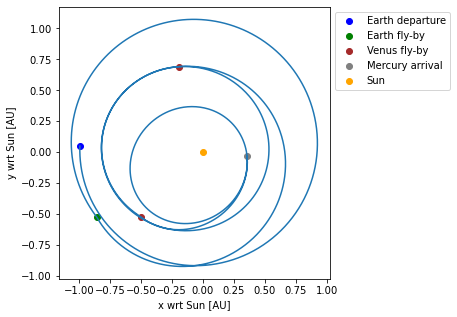

In [13]:
# Extract the state history
state_history = transfer_trajectory_object.states_along_trajectory(500)
fly_by_states = np.array([state_history[node_times[i]] for i in range(len(node_times))])
state_history = result2array(state_history)
au = 1.5e11

# Plot the state history
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(state_history[:, 1] / au, state_history[:, 2] / au)
ax.scatter(fly_by_states[0, 0] / au, fly_by_states[0, 1] / au, color='blue', label='Earth departure')
ax.scatter(fly_by_states[1, 0] / au, fly_by_states[1, 1] / au, color='green', label='Earth fly-by')
ax.scatter(fly_by_states[2, 0] / au, fly_by_states[2, 1] / au, color='brown', label='Venus fly-by')
ax.scatter(fly_by_states[3, 0] / au, fly_by_states[3, 1] / au, color='brown')
ax.scatter(fly_by_states[4, 0] / au, fly_by_states[4, 1] / au, color='grey', label='Mercury arrival')
ax.scatter([0], [0], color='orange', label='Sun')
ax.set_xlabel('x wrt Sun [AU]')
ax.set_ylabel('y wrt Sun [AU]')
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=[1, 1])
plt.show()